In [2]:
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt

## Generate Fractal Noise Using Inverse Fast Fourier Transform

In [3]:
# Parameters
beta = 4.5
sdim = 1024

In [4]:
# Set Seed
np.random.seed(117)

# Turn of div by zero warning
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [5]:
# Build power spectrum
sdim += 1
f = [x/sdim for x in range(0,int(sdim/2)+1)] + [x/sdim for x in range(-int(sdim/2),0)]
u = np.reshape(f, (sdim, 1))
v = np.reshape(f, (1, sdim))
powerspectrum = (u**2 + v**2)**(-beta/2)

# Patch any infinities
powerspectrum[powerspectrum == inf] = powerspectrum[0,1]

In [6]:
# Noise and ifft
phases = np.random.normal(127.5, 64, size=[sdim, sdim])
complexpattern = np.fft.ifft2(powerspectrum**0.5 * (np.cos(2*np.pi*phases)+1j*np.sin(2*np.pi*phases)))

In [7]:
# Normalize result between 0 and 1
realpattern = np.real(complexpattern)
realpattern = (realpattern-np.amin(realpattern))/np.amax(realpattern-np.amin(realpattern))

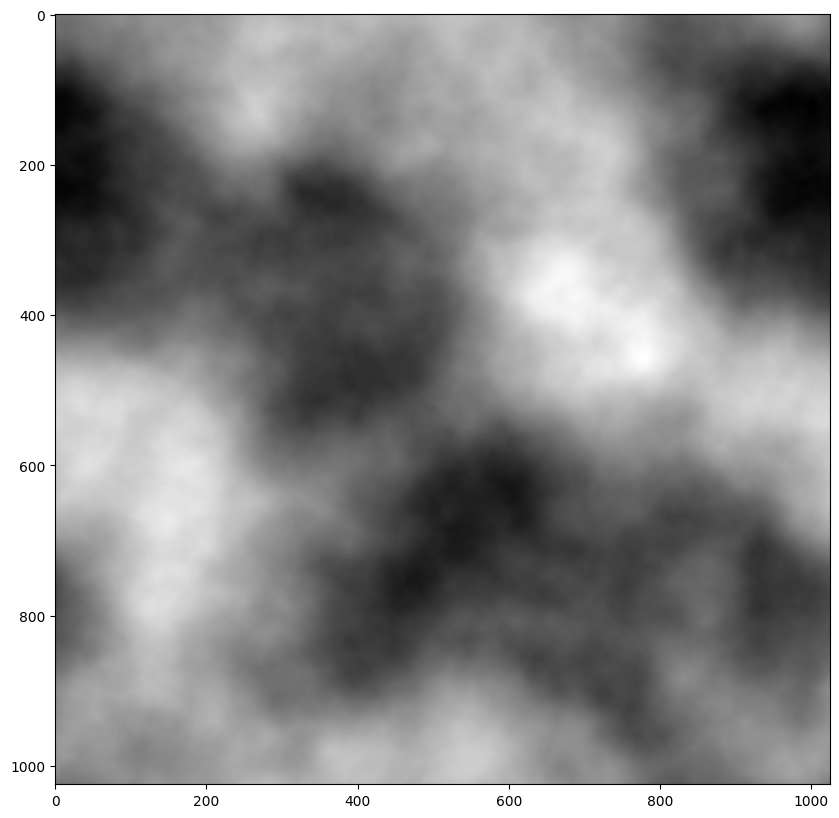

In [8]:
# Display result
plt.rcParams["figure.figsize"]=10,10
plt.imshow(realpattern, cmap='gray', vmin=0, vmax=1, aspect='auto')

## Singular Value Decomposition Experiment
#### We will decompose the matrix to rank 1 singular value layers, then attempt to rebuild the original matrix.

In [9]:
# SVD
U, E, V = np.linalg.svd(realpattern, compute_uv=True)

In [10]:
# Compute each SVD layer and add to layers list
A_layers = []

for i in range(len(U)):
    U_vec = U[:,i]
    U_vec = U_vec.reshape(-1,1)
    V_vec = V[i,:]
    V_vec = V_vec.reshape(1,-1)

    Ai = U_vec * E[i] * V_vec
    A_layers.append(Ai)

In [11]:
# Rebuild realpattern by summing through layers
rebuild = np.zeros(realpattern.shape)

for layer in A_layers:
    rebuild += layer

rebuild = np.real(rebuild)

### Matrix Rebuilt from Singular Value Layers 

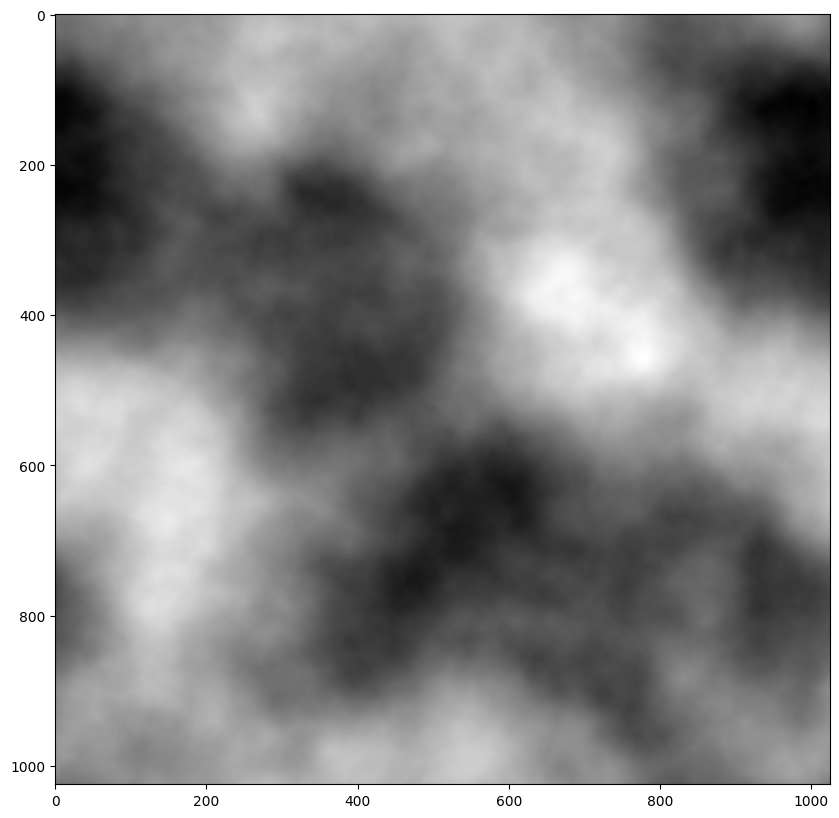

In [12]:
# Display result
plt.rcParams["figure.figsize"]=10,10
plt.imshow(np.real(rebuild), cmap='gray', aspect='auto')

In [13]:
# Check accuracy
realpattern - rebuild

array([[ 4.44089210e-16, -1.85407245e-14, -6.90558721e-14, ...,
        -9.65894031e-15, -1.08246745e-14, -4.77395901e-15],
       [-2.66453526e-15, -5.54001289e-14,  1.24511512e-13, ...,
        -5.60662627e-15, -6.93889390e-15, -9.27036226e-15],
       [-1.72084569e-15,  2.23709939e-14, -6.82787160e-15, ...,
         2.77555756e-16,  0.00000000e+00,  9.43689571e-16],
       ...,
       [-1.33226763e-15,  7.77156117e-16, -2.27595720e-15, ...,
        -1.55431223e-15, -1.05471187e-15, -2.60902411e-15],
       [-6.10622664e-16,  2.27595720e-15,  1.44328993e-15, ...,
        -9.43689571e-16, -8.32667268e-16, -4.99600361e-16],
       [-2.05391260e-15,  2.66453526e-15,  2.77555756e-15, ...,
        -1.60982339e-15, -1.66533454e-15, -4.99600361e-16]])

### Visualize Individual Singular Value Layers

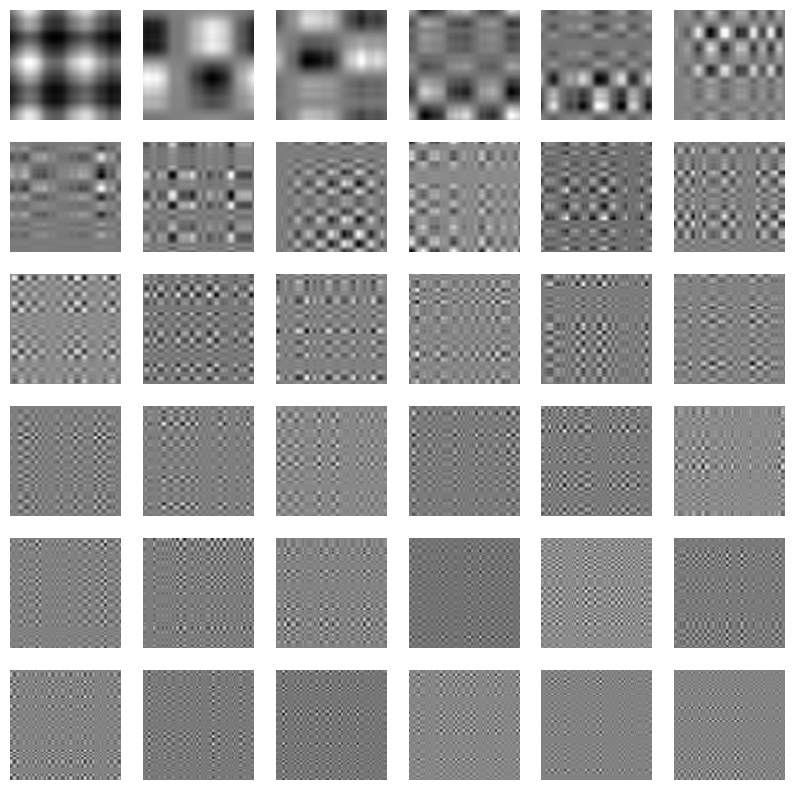

In [14]:
# Display some layers. Choose a square number.
layer_total = 36
grid_n = int(layer_total**.5)

assert layer_total // grid_n == grid_n, "Layer total must be square number."

plt.rcParams["figure.figsize"]=10,10

fig, axs = plt.subplots(grid_n, grid_n)

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Iterate through A_layers and plot each layer in a subplot
for ii, layer in enumerate(A_layers[:layer_total]):
    # Display each layer in the respective subplot
    axs[ii].imshow(np.real(layer), cmap='gray', aspect='auto')
    axs[ii].axis('off')

plt.show()

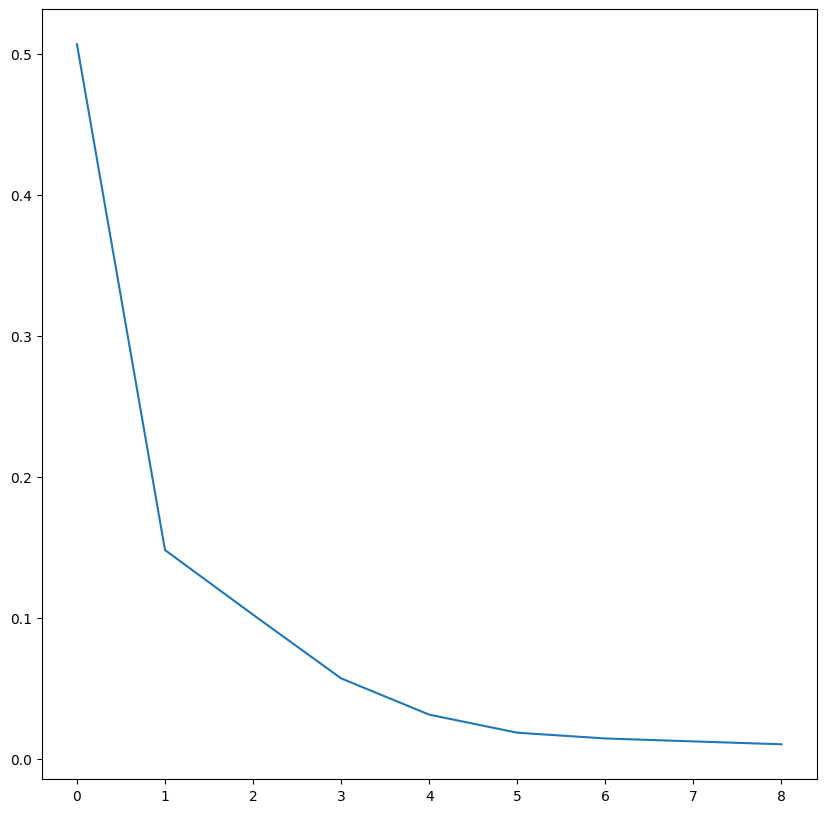

In [15]:
# Normalize all singular values in E between 0 and 1
E_total = np.sum(E)
for ii in range(len(E)):
    E[ii] /= E_total
    

# Look at contribution of singular values
count = [x for x in E if x > .01]
plt.plot(count)

In [16]:
# Variance explained?
sum(count)

0.9004841137273164

### Compressed Rebuilds

In [17]:
# Sum first 5 layers
sparse_rebuild = np.zeros(realpattern.shape)

for layer in A_layers[:5]:
    sparse_rebuild += layer

# Sum first 15 layers
medium_rebuild = np.zeros(realpattern.shape)

for layer in A_layers[:15]:
    medium_rebuild += layer

# List for plotting
matrices = [rebuild, medium_rebuild, sparse_rebuild]

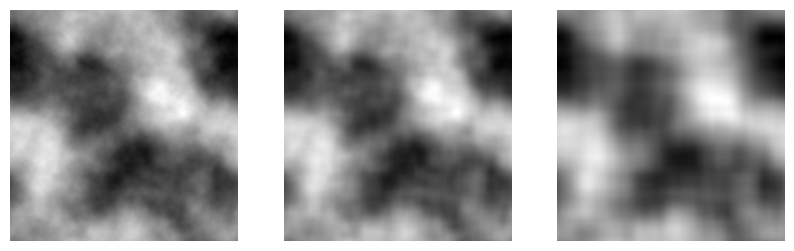

In [18]:
# Display result
plt.rcParams["figure.figsize"]=10,3
fig, axs = plt.subplots(1, 3)
axs = axs.flatten()

for ii in range(3):
    axs[ii].imshow(matrices[ii], cmap='gray', aspect='auto')
    axs[ii].axis('off')


In [19]:
print(np.linalg.matrix_rank(rebuild))
print(np.linalg.matrix_rank(medium_rebuild))
print(np.linalg.matrix_rank(sparse_rebuild))

1025
15
5


### SVD From Eigendecomposition

In [20]:
A = realpattern

In [21]:
E, U = np.linalg.eig(A@A.T)

In [22]:
e, V = np.linalg.eig(A.T@A)

In [23]:
print(E[:10])
print(e[:10])

[2.58815484e+05 2.20679124e+04 1.05091458e+04 3.27051252e+03
 9.82654194e+02 3.42140280e+02 2.07222134e+02 1.51222996e+02
 1.05156587e+02 6.65627362e+01]
[2.58815484e+05 2.20679124e+04 1.05091458e+04 3.27051252e+03
 9.82654194e+02 3.42140280e+02 2.07222134e+02 1.51222996e+02
 1.05156587e+02 6.65627362e+01]


In [24]:
# Get square roots of eigenvalues
E = np.diag(np.sqrt(E))
E.shape

(1025, 1025)

In [25]:
# Rebuild matrix
test = U@E@V.T

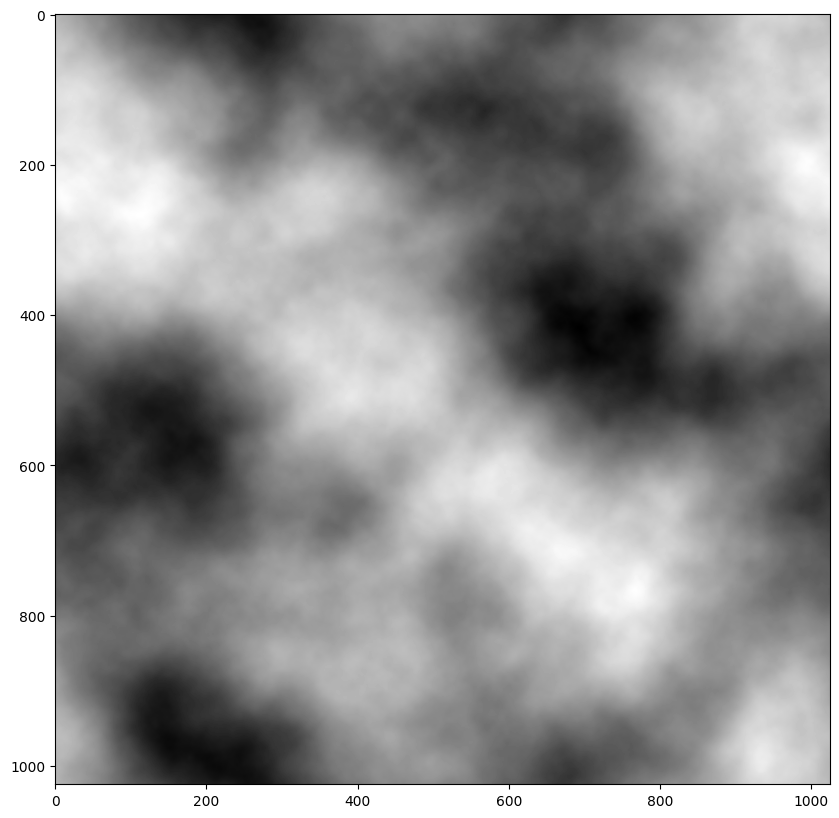

In [26]:
# Display result
plt.rcParams["figure.figsize"]=10,10
plt.imshow(test, cmap='gray', aspect='auto')

#### Test Rebuild Accuracy

In [27]:
np.linalg.norm(realpattern-test)

1082.529762154025

In [28]:
np.linalg.norm(realpattern-rebuild)

1.302315050208126e-12